### ML-7.Predicting biological response (HW-3)

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

![DataFreim](img/dst-3-ml-7-10.png)

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

![benchmarks](img/benchmarks.png)

#### Базовая оптимизация

In [10]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Подгружаем данные
data = pd.read_csv('data/train_sem09.csv')

data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Разделяем данные на признаки (X) и целевую переменную (y), делим выборку на тренировочную и тестовую
X = data.drop(['Activity'], axis=1)
y = data['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [11]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 500, solver='saga', random_state = 42)
# Обучаем модель
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.778


In [12]:
# Создаем объект класса случайный лес
rand_tree = ensemble.RandomForestClassifier(random_state=42)
# Обучаем модель
rand_tree.fit(X_train, y_train)
y_test_pred = rand_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.805


Значения f1-меры при гиперпараметрах, установленных по умолчанию, составляют: 
* для модели логистической регрессии - 0,778, 
* для модели случайного леса - 0,805

#### **Подбор гиперпараметров с использованием GridSearchCV**

In [13]:
from sklearn.model_selection import GridSearchCV

In [17]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test, y_test)))
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 12.6 s
Wall time: 8min 22s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}


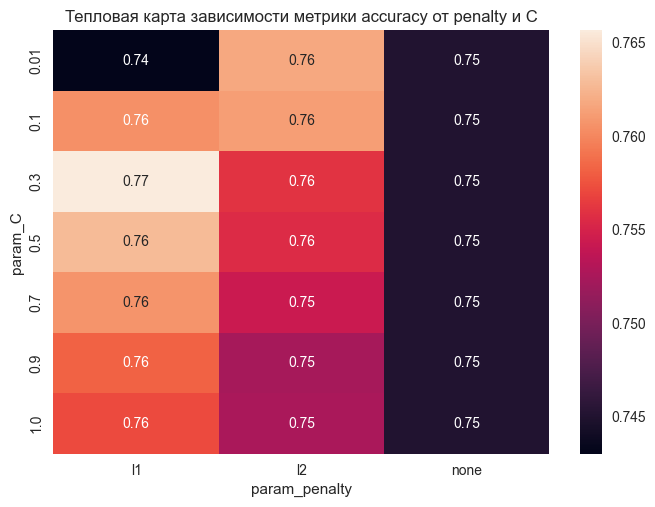

In [19]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_penalty')
sns.heatmap(visual, annot=True)
plt.title('Тепловая карта зависимости метрики accuracy от penalty и С') # подпись графика
sns.set(rc={'figure.figsize':(10, 4)}) #задаем размер графика

### Вывод:
**В результате оптимизации параметров методом gridsearch для логистической модели удалось улучшить метрику f1-score c 0.778 до 0.79.**

In [31]:
#подбор на модели случайного леса

param_grid = {'min_samples_leaf': list(np.linspace(1, 20, 10, dtype=int)),
              'max_depth': list(np.linspace(1, 15, 10, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train, y_train) 
y_test_pred = grid_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 13.5 s
Wall time: 15min 54s
f1_score на тестовом наборе: 0.801
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 1}


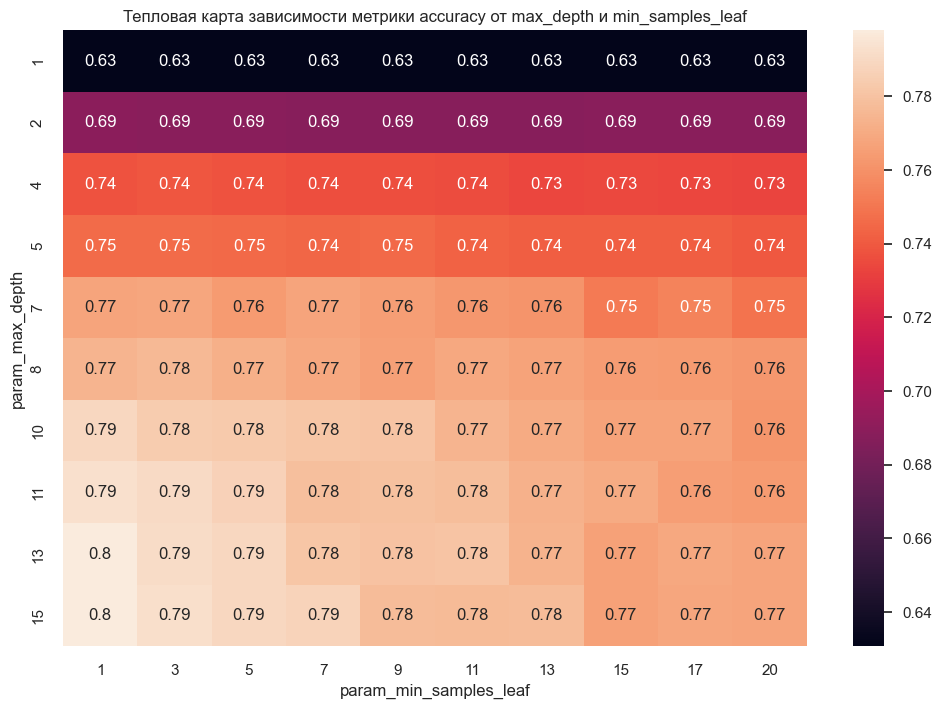

In [32]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_tree.cv_results_),
                        values='mean_test_score', index='param_max_depth',
                        columns='param_min_samples_leaf')
sns.heatmap(visual, annot=True)
plt.title('Тепловая карта зависимости метрики accuracy от max_depth и min_samples_leaf') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

#### Вывод:
**В результате оптимизации параметров методом gridsearch для модели случайного леса не удалось улучшить метрику f1-score (было 0.805, стало 0.801). Подбор наилучших параметров не дал существенного результата.**

### **RandomizedSearchCV**

С использованием класса RandomizedSearchCV из библиотеки scikit learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии, и случайного леса, а также сравним результаты с GridSearchCV и значениями по умолчанию.

In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [34]:
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 50, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=500), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 26.2 s
Wall time: 47min 33s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.05040816326530612}


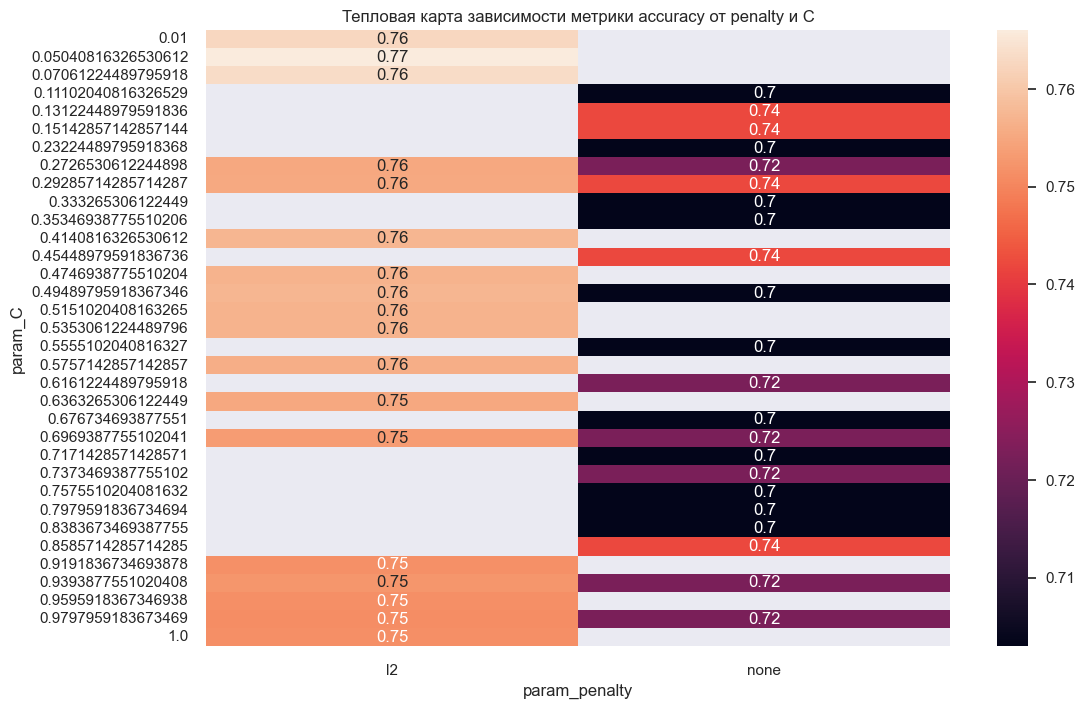

In [36]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(random_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_penalty')
sns.heatmap(visual, annot=True)
plt.title('Тепловая карта зависимости метрики accuracy от penalty и С') # подпись графика
sns.set(rc={'figure.figsize':(4, 20)}) #задаем размер графика

#### Вывод:
**В результате оптимизации параметров методом randomsearch для логистической регрессии значение метрики f1-score не улучшилось - 0.79**

In [39]:
# подбор на модели случайного леса
param_distributions = {'n_estimators': list(range(80, 200, 50)),
              'min_samples_leaf': list(np.linspace(1, 20, 10, dtype=int)),
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 9.3 s
Wall time: 6min 48s
f1_score на обучающем наборе: 1.00
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'n_estimators': 130, 'min_samples_leaf': 1, 'max_depth': 20}


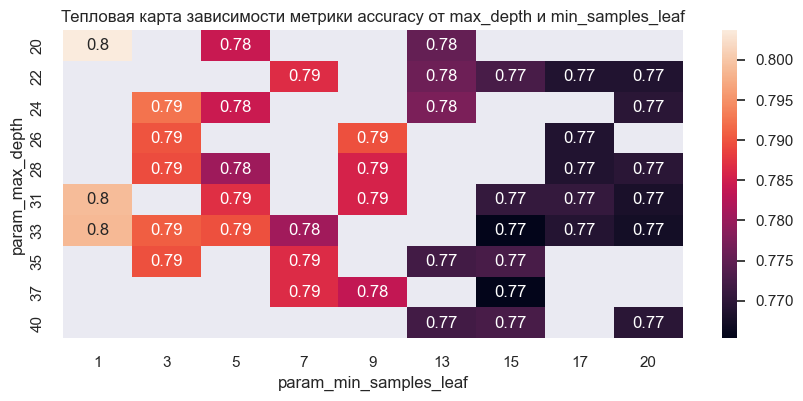

In [40]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(random_search_forest.cv_results_),
                        values='mean_test_score', index='param_max_depth',
                        columns='param_min_samples_leaf')
sns.heatmap(visual, annot=True)
plt.title('Тепловая карта зависимости метрики accuracy от max_depth и min_samples_leaf') # подпись графика
sns.set(rc={'figure.figsize':(10, 4)}) #задаем размер графика

#### Вывод:
**В результате оптимизации параметров методом randomsearch для модели случайного леса удалось улучшить метрику f1-score до 0.81.**

### Hyperopt

In [41]:
#делаем импорт
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

#### Hyperopt для логистической регрессии

In [42]:
# зададим пространство поиска гиперпараметров
space={'penalty': hp.choice('penalty', ['l2', 'l1']),
       'C': hp.uniform('C', 0.01, 1)
      }

In [43]:
#создаем функцию оптимизации гиперпараметров

def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'C': float(params['C'])
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, solver='saga', max_iter=500, random_state=42)

    # обучаем модель
    model.fit(X, y)
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [44]:
# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=10, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(seed=42) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 10/10 [43:04<00:00, 258.43s/trial, best loss: -0.7920651360713664]
Наилучшие значения гиперпараметров {'C': 0.16941386753130935, 'penalty': 1}


In [45]:
# cоздаём список penalty_list
penalty_list = ['l2', 'l1']


# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=42, 
    penalty=penalty_list[best['penalty']],
    C=float(best['C']),
    solver='saga', max_iter=500
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.776


В результате оптимизации параметров методом hyperopt для логистической значение метрики f1-score не удалось улучшить 0.776

#### Hyperopt для случайного леса

In [46]:
# задаём пространство для поиска гиперпараметров
space={'max_depth' : hp.quniform('max_depth', 1, 10, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 10, 20, 1)
      }

In [47]:
# создаём функцию оптимизации гиперпараметров

def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=42)

    # обучаем модель
    model.fit(X, y)
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [48]:
# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(seed=42) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 50/50 [06:09<00:00,  7.38s/trial, best loss: -0.7956677929156021]
Наилучшие значения гиперпараметров {'max_depth': 9.0, 'min_samples_leaf': 10.0}


In [49]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=42,
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.779


#### Вывод:
**В результате оптимизации параметров методом hyperopt для модели случайного леса не удалось улучшить метрику f1-score (0.779).**

### Optuna

In [50]:
import optuna

#### Optuna для логистической регрессии

In [51]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical("penalty", ['l2', 'l1'])
  c = trial.suggest_float('C', 0.01, 1)

  # создаем модель
  model = linear_model.LogisticRegression(penalty=penalty,
                                          C=c,
                                          solver='saga', max_iter=500,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [52]:
%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials
study_lr.optimize(optuna_lr, n_trials=10)

[I 2023-08-02 15:16:47,282] A new study created in memory with name: LogisticRegression


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-08-02 15:22:07,678] Trial 0 finished with value: 0.7884469400849803 and parameters: {'penalty': 'l1', 'C': 0.35376379521729373}. Best is trial 0 with value: 0.7884469400849803.
[I 2023-08-02 15:24:27,593] Trial 1 finished with value: 0.7779813394661839 and parameters: {'penalty': 'l2', 'C': 0.29924864341416796}. Best is trial 0 with value: 0.7884469400849803.
[I 2023-08-02 15:29:40,128] Trial 2 finished with value: 0.7872724243390621 and parameters: {'penalty': 'l1', 'C': 0.5110051518638635}. Best is trial 0 with value: 0.7884469400849803.
[I 2023-08-02 15:33:34,071] Trial 3 finished with value: 0.779494746167446 and parameters: {'penalty': 'l2', 'C': 0.6088282587527023}. Best is trial 0 with value: 0.7884469400849803.
[I 2023-08-02 15:38:46,487] Trial 4 finished with value: 0.7881039426202119 and parameters: {'penalty': 'l1', 'C': 0.5149339465584767}. Best is trial 0 with value: 0.7884469400849803.
[I 2023-08-02 15:41:25,540] Trial 5 finished with value: 0.7773692268094512 and

In [53]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_lr.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study_lr.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l1', 'C': 0.25059569967106526}
f1_score на обучающем наборе: 0.790


In [54]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study_lr.best_params, solver='saga', max_iter=500, random_state=42)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.781


In [55]:
# отследим динамику оптимизации признака
optuna.visualization.plot_optimization_history(study_lr, target_name="f1_score")

#### Вывод:
**В результате оптимизации параметров методом optuna для модели логистической регрессии не удалось улучшить метрику f1-score.**

#### Optuna для случайного леса

In [56]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [57]:
%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=50)

[I 2023-08-02 17:16:40,018] A new study created in memory with name: RandomForestClassifier


CPU times: total: 0 ns
Wall time: 0 ns


[I 2023-08-02 17:16:59,769] Trial 0 finished with value: 0.8029320972689395 and parameters: {'max_depth': 28, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8029320972689395.
[I 2023-08-02 17:17:12,267] Trial 1 finished with value: 0.8070232274584827 and parameters: {'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8070232274584827.
[I 2023-08-02 17:17:27,136] Trial 2 finished with value: 0.811606210170803 and parameters: {'max_depth': 21, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.811606210170803.
[I 2023-08-02 17:17:37,794] Trial 3 finished with value: 0.813048099485089 and parameters: {'max_depth': 14, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.813048099485089.
[I 2023-08-02 17:17:51,249] Trial 4 finished with value: 0.817033982855623 and parameters: {'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 4 with value: 0.817033982855623.
[I 2023-08-02 17:18:03,784] Trial 5 finished with value: 0.8112650613480683 and parameters: {'ma

In [58]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study_rf.best_value))

Наилучшие значения гиперпараметров {'max_depth': 17, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.818


In [59]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=42)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.793


In [60]:
# отследим динамику оптимизации признака
optuna.visualization.plot_optimization_history(study_rf, target_name="f1_score")

#### Вывод:
**В результате оптимизации параметров методом optuna для модели случайного леса нам не удалось улучшить метрику f1-score.**

### Построим графики важности гиперпараметров

In [63]:
optuna.visualization.plot_param_importances(study_lr, target_name="f1_score")

In [62]:
optuna.visualization.plot_param_importances(study_rf, target_name="f1_score")

### Построим графики контура отношений гиперпараметров

In [65]:
optuna.visualization.plot_contour(study_lr, params=["penalty", "C"],
                                  target_name="f1_score")

In [67]:
optuna.visualization.plot_contour(study_rf, params=["max_depth", "min_samples_leaf"],
                                  target_name="f1_score")